In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gurobipy import *
import gurobipy as gp
from gurobipy import GRB
import os
sns.set(style ="whitegrid", font_scale=1.5)
from matplotlib.ticker import MultipleLocator
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
custom_colors = ["#c45161", "#e094a0", "#f2b6c0", "#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"]
cmap_colors = ["#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)
color_palette = np.array(["#c45161", "#e094a0", "#f2b6c0", "#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"])
matplotlib.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})
from tqdm import tqdm
import sys
import os
import pickle
import importlib
import re
from scipy.stats import norm
from scipy.linalg import sqrtm
import scipy.sparse as sp
from scipy.stats import skewnorm

### Data Processing

In [2]:
import importlib
import utils
importlib.reload(utils)
from utils import calc_cum_arrive, calc_cum_depart #, calc_wasted_capacity

In [3]:
df = pd.read_excel('BCN.xlsx').iloc[:260,:]
df['Time'] = pd.to_timedelta(df['Time'].astype(str))
df['minutes'] = df['Time'].dt.total_seconds() / 60
df['slots'] = df['minutes'] // 15
df = df[['Aircraft Capacity', 'slots']] 
latest_arrival = df['slots'].to_numpy()

In [4]:
c = np.zeros(shape=(df.shape[0], 96))
for i in range(df.shape[0]):
    mean_security_time = df['slots'].iloc[i] - 4
    for j in range(96):
        if j < mean_security_time:
            c[i,j] = (mean_security_time-j)**2
        elif j > mean_security_time:
            c[i,j] = j-mean_security_time

### Run Model

In [188]:
import model
importlib.reload(model)
from model import ROSecurity

In [195]:
inst = ROSecurity(df, n_slots=96, cost=c)
solution = inst.run(capacity=800, gamma=0.01, alpha=0.8, sigma=0.2)

100%|██████████| 260/260 [00:00<00:00, 33673.58it/s]

Set parameter NonConvex to value 2


### Visualization

In [100]:
matplotlib.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})

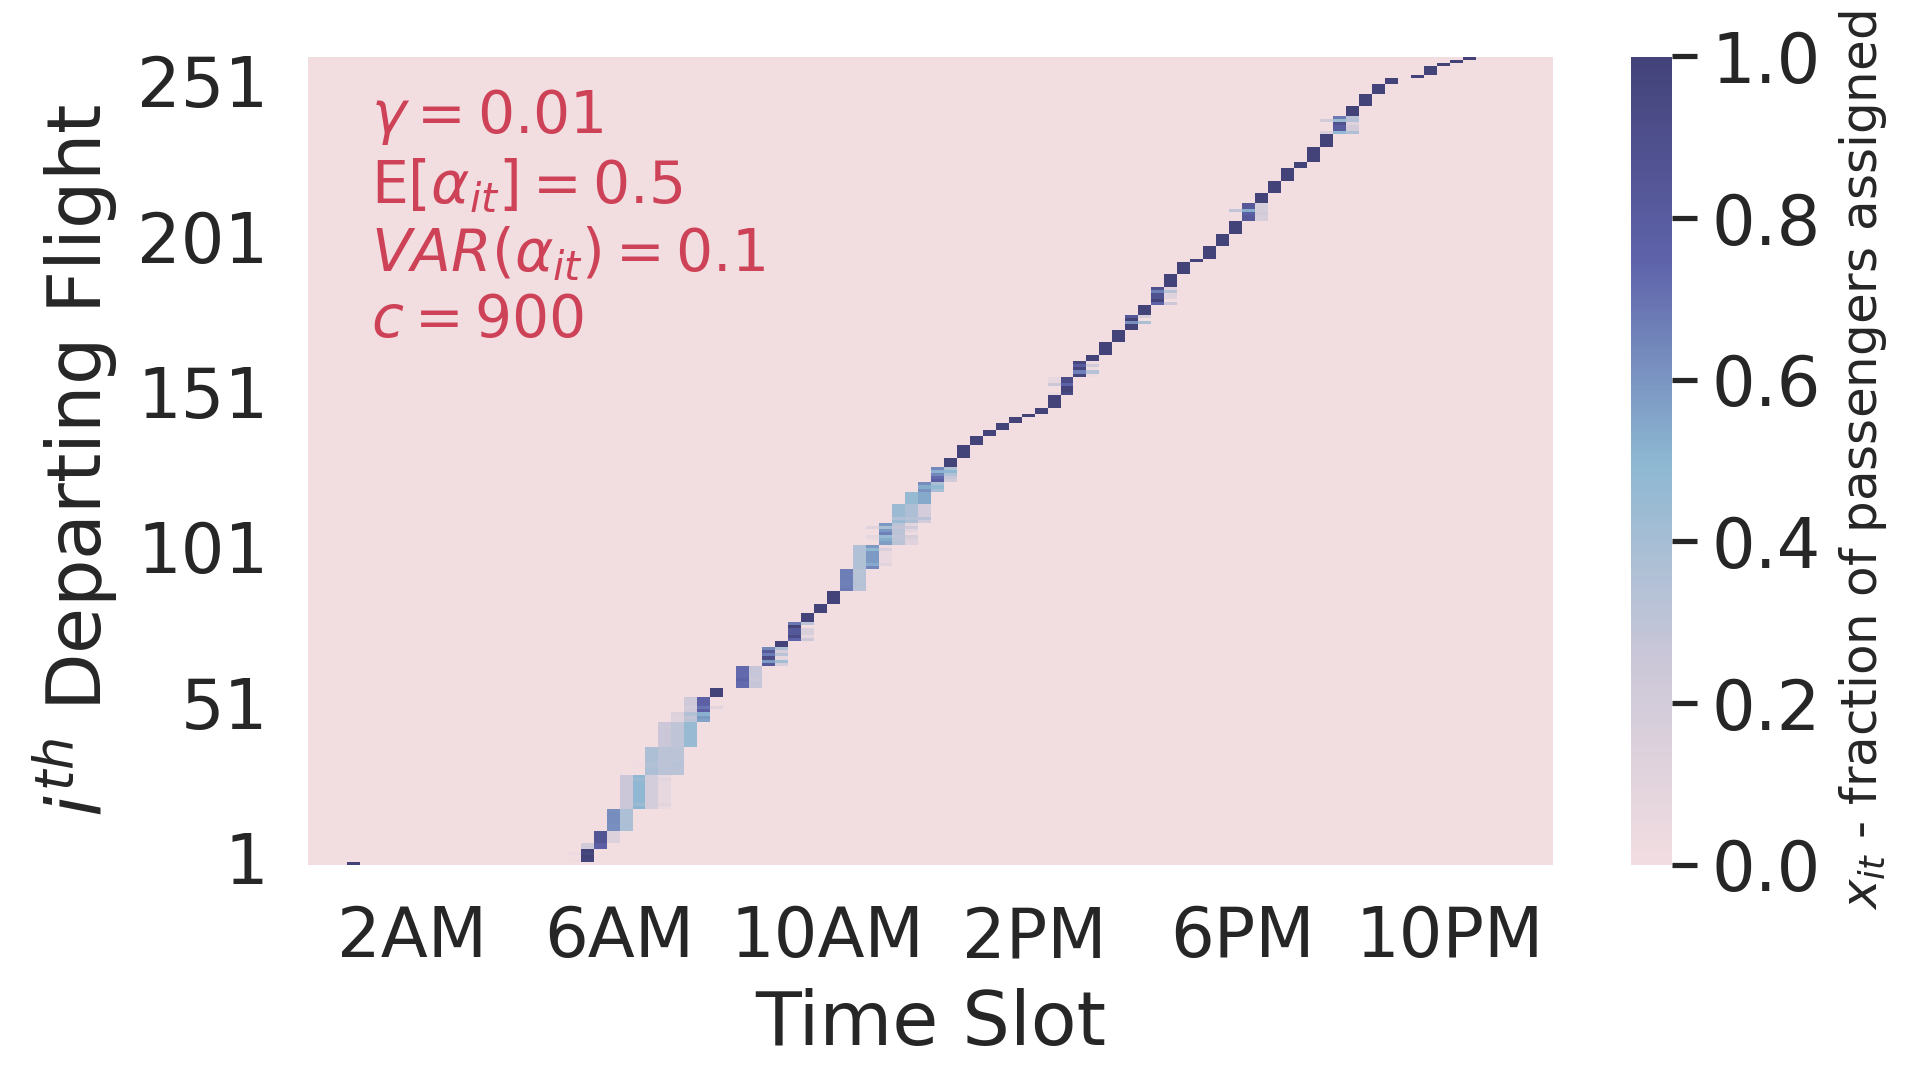

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(6.75,4), dpi=300)
sns.heatmap(solution, cmap=cmap, ax=ax)
ax.set(xlabel='Time Slot', ylabel=r'$i^{th}$ Departing Flight', 
       xticks = [i*16-8 for i in range(1,7)],
       xticklabels=['2AM', '6AM', '10AM', '2PM', '6PM', '10PM'],
       yticks = [i*50 for i in range(6)],
       yticklabels=[i for i in range(1, 301, 50)])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel(r"$x_{it}$ - fraction of passengers assigned", fontsize=12) 
ax.text(
    0.05, 0.80, 
    r'$\gamma = 0.01$' + '\n' + 
    r'$\mathrm{E}[\alpha_{it}]=0.5$' + '\n' +
    r'$VAR(\alpha_{it})=0.1$' + '\n' + 
    r'$c=900$', 
    ha='left', va='center', 
    transform=ax.transAxes, 
    fontsize=14, 
    color='#ce4257'
)

plt.tight_layout()
ax.invert_yaxis()

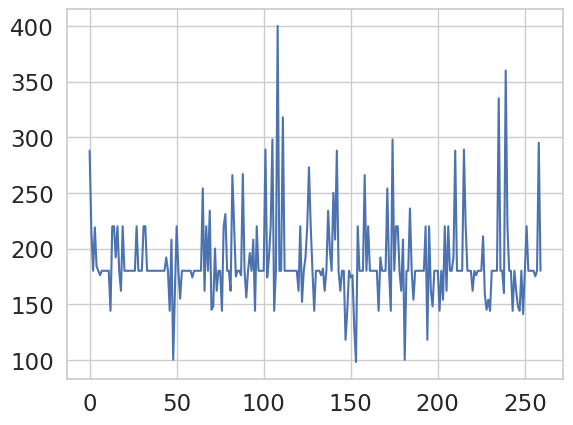

In [66]:
plt.plot(df['Aircraft Capacity'])

In [136]:
inst = ROSecurity(df, n_slots=96, cost=c)
solution = inst.run(capacity=900, gamma=0.2, alpha=0.6, sigma=0.1, n_neighbor=1)

100%|██████████| 260/260 [00:00<00:00, 35874.70it/s]


Set parameter NonConvex to value 2


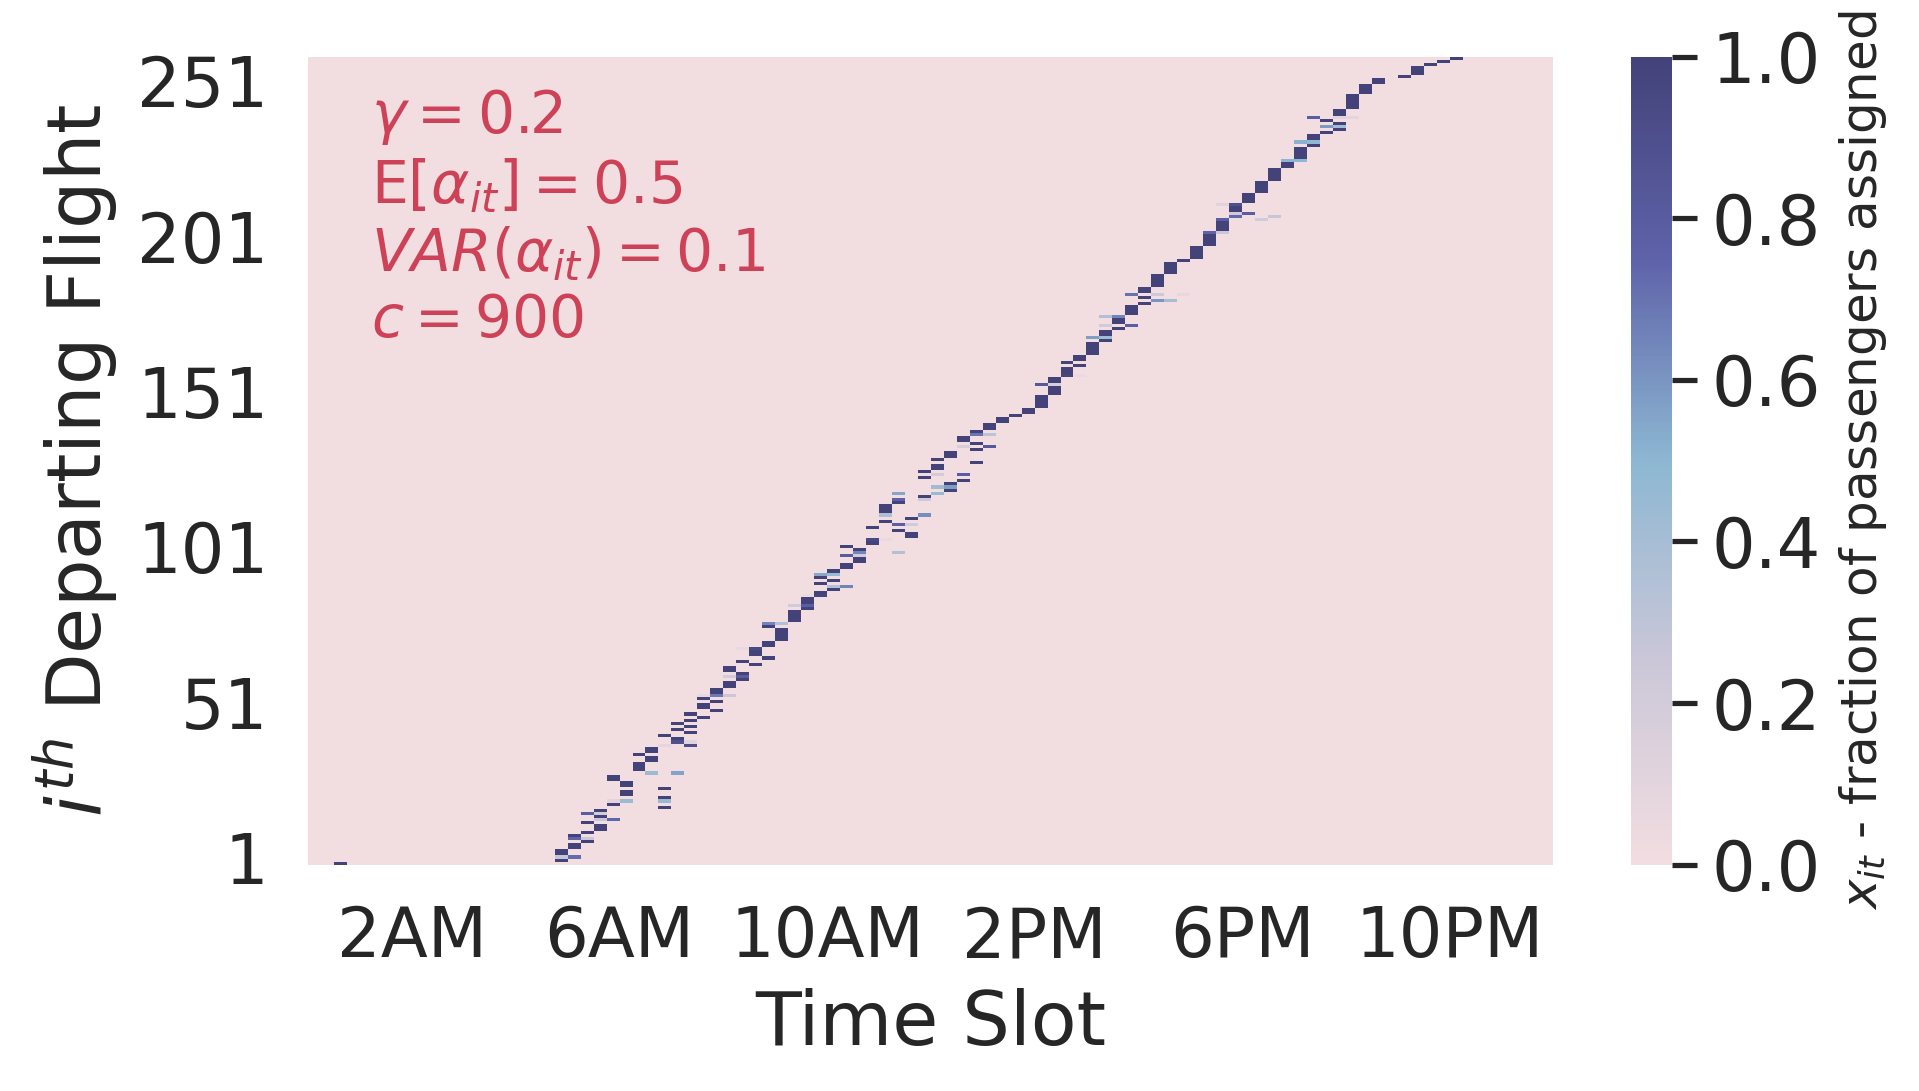

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(6.75,4), dpi=300)
sns.heatmap(deterministic, cmap=cmap, ax=ax)
ax.set(xlabel='Time Slot', ylabel=r'$i^{th}$ Departing Flight', 
       xticks = [i*16-8 for i in range(1,7)],
       xticklabels=['2AM', '6AM', '10AM', '2PM', '6PM', '10PM'],
       yticks = [i*50 for i in range(6)],
       yticklabels=[i for i in range(1, 301, 50)])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel(r"$x_{it}$ - fraction of passengers assigned", fontsize=12) 
ax.text(
    0.05, 0.80, 
    r'$\gamma = 0.2$' + '\n' + 
    r'$\mathrm{E}[\alpha_{it}]=0.5$' + '\n' +
    r'$VAR(\alpha_{it})=0.1$' + '\n' + 
    r'$c=900$', 
    ha='left', va='center', 
    transform=ax.transAxes, 
    fontsize=14, 
    color='#ce4257'
)

plt.tight_layout()
ax.invert_yaxis()

In [75]:
m = Model('Assignment')
x = m.addVars(c.shape[0], c.shape[1], vtype=GRB.CONTINUOUS, name='x')
for i in tqdm(range(c.shape[0])):
    m.addConstr(quicksum(x[i,j] for j in range(c.shape[1])) == 1)
for j in tqdm(range(c.shape[1])):
    m.addConstr(quicksum(x[i,j]*df['Aircraft Capacity'][i] for i in range(c.shape[0])) <= 800)
for idx, desired_arrival in enumerate(inst.latest_arrival_time):
    m.addConstr(quicksum(x[idx, j] for j in range(int(desired_arrival), int(c.shape[1]))) == 0)

m.setObjective(quicksum(x[i,j]*c[i,j]*df['Aircraft Capacity'][i] for i in range(c.shape[0]) for j in range(c.shape[1])), GRB.MINIMIZE)
m.update()
m.setParam('OutputFlag', 0)
m.optimize()
deterministic = np.zeros((c.shape[0], c.shape[1]))
for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        deterministic[i, j] = m.getVarByName(f'x[{i},{j}]').x



100%|██████████| 96/96 [00:00<00:00, 1902.06it/s]


### Queuing
 

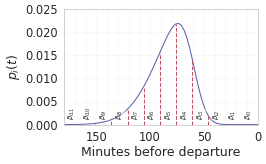

In [76]:
from scipy.stats import skewnorm
#pg292
mu = 60     # Mean
sigma = 30   # Standard deviation
alpha = 3    # Skewness

# Define the skew-normal distribution
x = np.linspace(0, 180, 72)  # Range for x values
pdf = skewnorm.pdf(x, alpha, loc=mu, scale=sigma)  # Probability density function
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=50)
ax.plot(x, pdf, color=color_palette[-2])
for t in range(12):
    ax.plot([t*15+1, t*15+1], [0, pdf[t*6]], color=color_palette[0], linestyle='--')
    ax.text(t*15+8, 0.001, fr"$\beta_{{{{i}}{t}}}$", ha='center', va='bottom', fontsize=10, rotation=90,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.05', alpha=0.5))
ax.set(xlim=(0, 180), ylim=(0, 0.025), 
       xlabel='Minutes before departure', ylabel=r'$p_{i}(t)$')

ax.invert_xaxis()
minorLocator = MultipleLocator(10)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(True, alpha=0.25, linestyle='--', which='both')

In [159]:


def calc_prob_den(solution, inst):
    np.random.seed(20)
    prob = np.zeros(shape=(solution.shape[0], solution.shape[1]))
    for i in range(solution.shape[0]):
        beta_i = []
        for j in range(solution.shape[1]):
            diff = inst.latest_arrival_time[i] - j - 1
            if diff >= 0 and diff <= 15:
                beta_i.append(inst.pmf[diff])
            else:
                beta_i.append(0)
        beta_i = np.array(beta_i)
        prob_i = np.zeros(shape=(solution.shape[1]))
        for t in range(solution.shape[1]):
            alpha_t = np.random.normal(inst.alpha[i,t], inst.sigma)
            prob_i[t] += alpha_t * solution[i,t]
            for s in range(solution.shape[1]):
                prob_i[s] += (solution[i,t] * (1-alpha_t) * beta_i[s])

        prob[i] = prob_i
    return prob

def generate_assigned_arrivals(realized, df=df):
    np.random.seed(20)
    realized[realized < 1e-10] = 0
    arrival_time = np.array([])
    for i in range(realized.shape[0]):
        arrival_time_sample = np.random.choice(np.arange(realized.shape[1]), size=int(df['Aircraft Capacity'][i]), p=realized[i]/realized[i].sum())
        arrival_time = np.concatenate([arrival_time, arrival_time_sample])

    return arrival_time


In [196]:
realized = calc_prob_den(solution, inst)
reassigned_arrival = generate_assigned_arrivals(realized)
deterministic_realized = calc_prob_den(deterministic, inst)
deterministic_reassigned_arrival = generate_assigned_arrivals(deterministic_realized)

In [171]:
arrival_time = np.array([])
for idx, row in df.iterrows():
    sampled_lead_time = skewnorm.rvs(alpha, loc=mu, scale=sigma, size=int(row['Aircraft Capacity'])) // 15
    arrival_time = np.concatenate([arrival_time, row['slots'] - sampled_lead_time])

    arrival_time[arrival_time < 0] = 0

In [172]:
departing_time = np.array([])
for idx, row in df.iterrows():
    departing_time_i = np.repeat(row['slots'], int(row['Aircraft Capacity']))
    departing_time = np.concatenate([departing_time, departing_time_i])

In [197]:
cum_arr = calc_cum_arrive(arrival_time)
cum_dep = calc_cum_depart(arrival_time, 800)

assigned_arrival = calc_cum_arrive(reassigned_arrival)
assigned_depature = calc_cum_depart(reassigned_arrival, 800)

deterministic_arrival = calc_cum_arrive(deterministic_reassigned_arrival)
deterministic_depature = calc_cum_depart(deterministic_reassigned_arrival, 800)

flight_dep = calc_cum_arrive(departing_time)

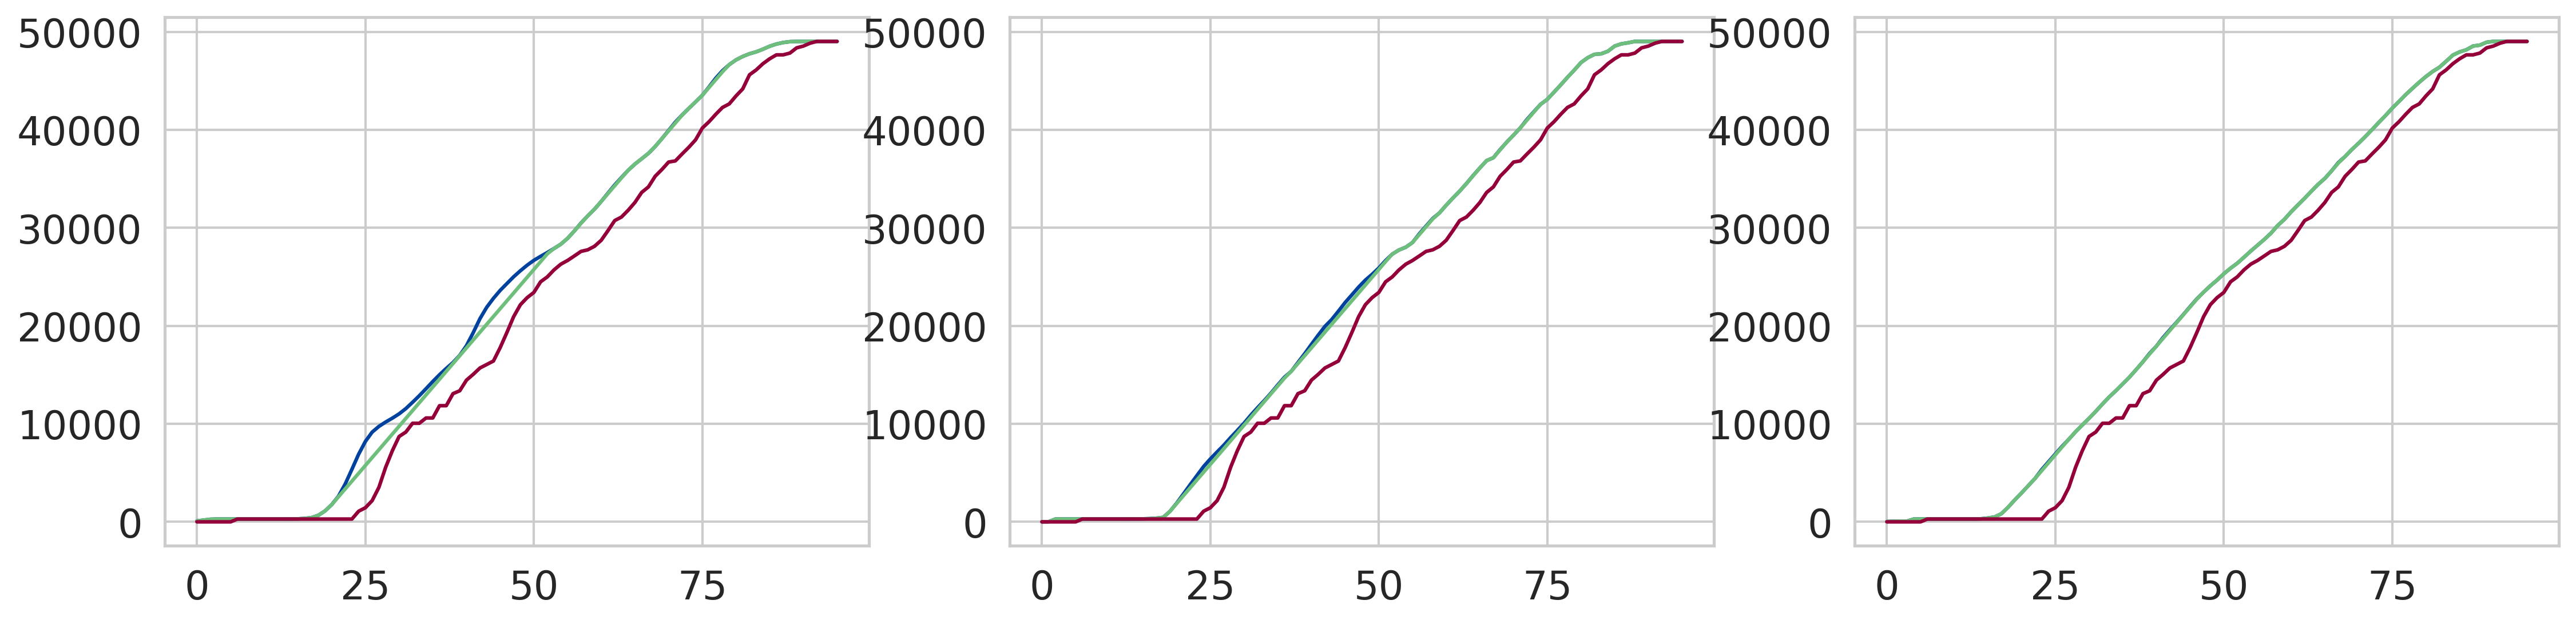

In [198]:
color_s = ['#93003a', '#00429d', '#93c4d2', '#6ebf7c']

fig, ax = plt.subplots(1, 3, figsize=(18, 4), dpi=300)

ax[0].plot(cum_arr, color = color_s[1])
ax[0].plot(cum_dep, color = color_s[3])
ax[0].plot(flight_dep, color = color_s[0])

ax[1].plot(deterministic_arrival, color = color_s[1])
ax[1].plot(deterministic_depature, color = color_s[3])
ax[1].plot(flight_dep, color = color_s[0])

ax[2].plot(assigned_arrival, color = color_s[1])
ax[2].plot(assigned_depature, color = color_s[3])
ax[2].plot(flight_dep, color = color_s[0])



# ax.set(title='Cumulative Arrival at Security when Hourly Capacity = 48 \n (1% Down Sample)' )
# ax.legend(title='', bbox_to_anchor=(-0.05, -0.1), loc='upper left')

# minorLocator = MultipleLocator(4)
# ax.xaxis.set_minor_locator(minorLocator)
# ax.grid(True, alpha=0.25, linestyle='--', which='both')
# ax.set(xlabel='', ylabel='Number of Passengers * 1%', xlim=(0, 96), ylim=(0, 550));
# ax.set(xticks=[i*16 for i in range(6)]+[96], xticklabels=[f"{i*4}:00" for i in range(6)]+[f"{0}:00"])

In [199]:
np.sum((assigned_arrival-assigned_depature)*15)

10830

In [200]:
np.sum((deterministic_arrival-deterministic_depature)*15)

157395

In [203]:
det_cost = 0
robust_cost = 0
for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        det_cost += c[i,j]*deterministic[i,j]*df['Aircraft Capacity'][i]
        robust_cost += c[i,j]*solution[i,j]*df['Aircraft Capacity'][i]


In [204]:
det_cost

32126.0

In [205]:
robust_cost

393808.368219049